In [1]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if "/home/alex/qi3/hmmtuf" not in sys.path:
    sys.path.append("/home/alex/qi3/hmmtuf")

In [3]:
from db.sqlite3_db_connector import SQLiteDBConnector
from compute_engine.src.utils import count_kmers
from compute_engine.src.utils import INFO
from compute_engine.src.cpf import map_seq_to_category
from compute_engine.src.utils import get_max_kmers

In [4]:
# connect to the DB
db_connector = SQLiteDBConnector(db_file="../../play_ground.sqlite3")

In [5]:
MIN_REPEAT_LENGTH = 10
N_BEST_COUNTS = 5
KMER_LENGTH = 4

In [6]:
def insert_or_update(kmers_old, kmers_new):
    
    for item in kmers_new:
        if item in kmers_old:
            kmers_old[item] += kmers_new[item]
        else:
            kmers_old[item] = kmers_new[item]
            

In [7]:
tbl_names = db_connector.get_table_names()
print("{0} DB table names: {1}".format(INFO, tbl_names))

INFO: DB table names: ['distance_metric_type', 'distance_sequence_type', 'repeats', 'hmm_state_types', 'repeats_distances', 'repeats_info', 'gquads_info']


In [8]:
print(db_connector.get_table_column_names(table_name='repeats'))

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'chromosome', 'TEXT', 1, None, 0), (2, 'start_idx', 'INT', 1, None, 0), (3, 'end_idx', 'INT', 1, None, 0), (4, 'repeat_seq', 'TEXT', 1, None, 0), (5, 'hmm_state_id', 'INTEGER', 1, None, 0), (6, 'gc', 'FLOAT', 0, None, 0)]


In [9]:
print(db_connector.get_table_column_names(table_name='repeats_info'))

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'chromosome', 'TEXT', 1, None, 0), (2, 'start_idx', 'INTEGER', 1, None, 0), (3, 'end_idx', 'INTEGER', 1, None, 0), (4, 'max_repeats_count', 'INTEGER', 1, None, 0), (5, 'align_seq', 'TEXT', 1, None, 0), (6, 'unit_seq', 'TEXT', 1, None, 0)]


In [10]:
# repeat sequences and their state
sql = "SELECT repeats_info.id, repeats_info.chromosome, repeats_info.start_idx, \
repeats_info.end_idx,  repeats_info.max_repeats_count, repeats_info.align_seq, repeats_info.unit_seq,\
repeats.hmm_state_id FROM repeats_info JOIN repeats WHERE  repeats.start_idx=repeats_info.start_idx AND \
repeats.end_idx=repeats_info.end_idx AND repeats_info.chromosome=repeats.chromosome"

In [11]:
repeats_info = db_connector.fetch_all(sql=sql)
print("{0} Number of repeats={1}".format(INFO, len(repeats_info)))

INFO: Number of repeats=4066


In [12]:
hmm_states = db_connector.fetch_from_hmm_state_types_all()
print("{0} HMM states {1}".format(INFO, hmm_states))

INFO: HMM states [(1, 'NORMAL'), (2, 'TUF'), (3, 'DELETION'), (4, 'DUPLICATION')]


In [13]:
hmm_states_map = dict()

for item in hmm_states:
    hmm_states_map[item[0]] = item[1]

In [14]:
total_kmers = {}

In [15]:
for repeat in repeats_info:
    
    repeat_id = repeat[0]
    repeat_chromosome = repeat[1]
    repeat_start_idx = repeat[2]
    repeat_end_idx = repeat[3]
    repeat_max_repeats_count = repeat[4]
    repeat_align_seq = repeat[5]
    repeat_unit_seq = repeat[6]
    region_hmm_state_id = repeat[7]
    
    if 'M' in repeat_align_seq or 'm' in repeat_align_seq:
        print("{0} Detected invalid align sequence ".format(INFO))
        continue
    
    kmers = count_kmers(sequence=repeat_align_seq, k=KMER_LENGTH)
    top_kmers = get_max_kmers(kmers=kmers, min_count=N_BEST_COUNTS)
    total_kmers[repeat_id] = (top_kmers, hmm_states_map[region_hmm_state_id])
    

INFO: Detected invalid align sequence 


In [16]:
# arrange kmers according to HMM state
hmm_kmers = {}

for idx in hmm_states_map:
    hmm_kmers[hmm_states_map[idx]] = dict()

for item in total_kmers:
    item_data = total_kmers[item] 
    insert_or_update(kmers_old=hmm_kmers[item_data[1]], kmers_new=item_data[0])
        

In [17]:
for state in hmm_kmers:
    print("{0} state {1} has {2} kmers".format(INFO, state, len(hmm_kmers[state])))

INFO: state NORMAL has 217 kmers
INFO: state TUF has 242 kmers
INFO: state DELETION has 204 kmers
INFO: state DUPLICATION has 0 kmers


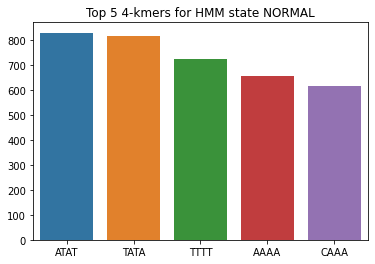

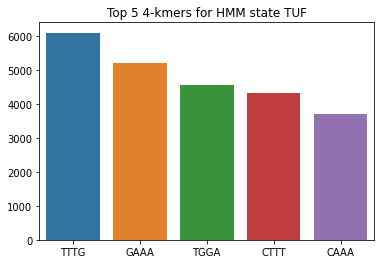

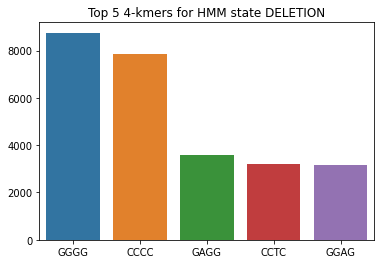

In [18]:
# get best kmers
top_best_kmers = {}

for state in hmm_kmers:
    
    if len(hmm_kmers[state]) == 0:
        continue
    
    top_state_kmers = get_max_kmers(hmm_kmers[state], min_count=N_BEST_COUNTS)
    #top_best_kmers[state] = top_state_kmers
    
    kmer_names = [name for name in top_state_kmers]
    frequencies = [top_state_kmers[item] for item in top_state_kmers]
    sns.barplot(x=kmer_names, y=frequencies)# palette=clrs)
    plt.title("Top {0} {1}-kmers for HMM state {2}".format(N_BEST_COUNTS, KMER_LENGTH, state))
    plt.show()

In [19]:
categories = {'C1': {"R": ['A', 'G'], "Y": ["C", "T"]},
              'C2': {"M": ['A', 'C'], "K": ["G", "T"]},
              'C3': {"W": ['A', 'T'], "S": ["C", "G"]}}

In [20]:
count = 0
total_kmers_per_category = {}
for repeat in repeats_info:
    
    repeat_id = repeat[0]
    repeat_chromosome = repeat[1]
    repeat_start_idx = repeat[2]
    repeat_end_idx = repeat[3]
    repeat_max_repeats_count = repeat[4]
    repeat_align_seq = repeat[5]
    repeat_unit_seq = repeat[6]
    region_hmm_state_id = repeat[7]
    
    if 'M' in repeat_align_seq or 'm' in repeat_align_seq:
        continue
    
    total_kmers_per_category[repeat_id] = {}
    
    for c in categories:
       
        try:
            kmers = count_kmers(sequence=map_seq_to_category(categories[c], seq=repeat_align_seq), k=KMER_LENGTH)
            top_kmers = get_max_kmers(kmers=kmers, min_count=N_BEST_COUNTS)
            total_kmers_per_category[repeat_id][c] = (top_kmers, hmm_states_map[region_hmm_state_id])
        except ValueError as e:
            print("{0} Category {1}".format(INFO, c))
            print("{0} Used sequence {1}".format(INFO,repeat_align_seq)) 
            print(str(e))
            
    

In [21]:
# arrange kmers according to HMM state and category
hmm_kmers_category = {}

for item in hmm_states:
    hmm_kmers_category[item[1]] = dict()
    
    for c in categories:
        hmm_kmers_category[item[1]][c] = dict()
        

for item in total_kmers_per_category:
    for c in categories:
    
        item_data = total_kmers_per_category[item][c]
        insert_or_update(kmers_old=hmm_kmers_category[item_data[1]][c], kmers_new=item_data[0])

INFO: Working with state NORMAL


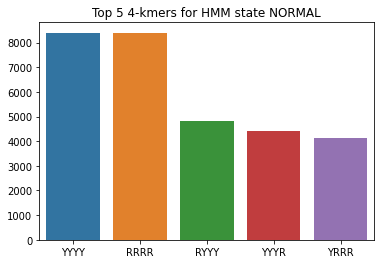

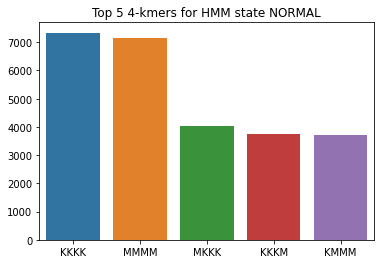

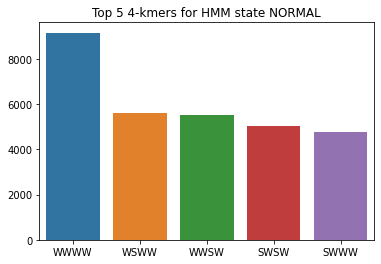

INFO: Working with state TUF


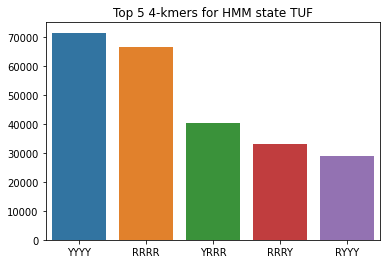

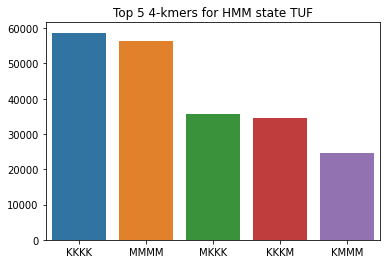

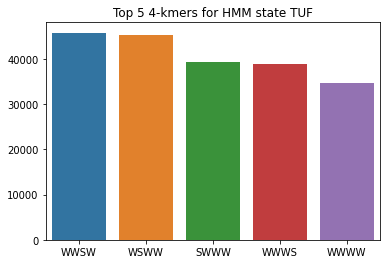

INFO: Working with state DELETION


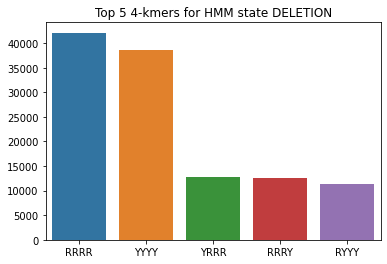

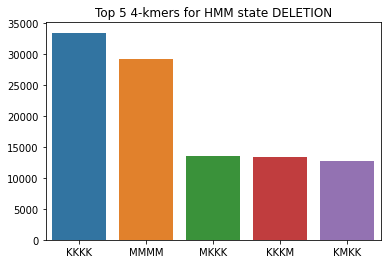

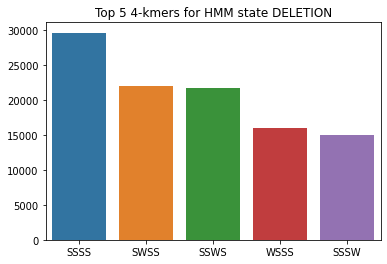

In [22]:
# get top five kmers
top_best_kmers = {}

for state in hmm_kmers_category:
    
    if state == 'DUPLICATION':
        continue
        
    print("{0} Working with state {1}".format(INFO, state))
    
    #fig, axs = plt.subplots(ncols=3)
    #fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
    #fig.subplots_adjust(hspace=0.1, wspace=0.2)
    
    for i, c in enumerate(categories):
    
        top_state_kmers = get_max_kmers(hmm_kmers_category[state][c], min_count=N_BEST_COUNTS)
    
        kmer_names = [name for name in top_state_kmers]
        frequencies = [top_state_kmers[item] for item in top_state_kmers]
        
        #ax = sns.barplot(x=kmer_names, y=frequencies, ax=axs[i])
        sns.barplot(x=kmer_names, y=frequencies) #, ax=axs[i])
        
        
        plt.title("Top {0} {1}-kmers for HMM state {2}".format(N_BEST_COUNTS, KMER_LENGTH, state))
        plt.show()